# Kwantowy model klasyfikatora wariacyjnego



## Załadowanie danych

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
features = iris.data
labels = iris.target

## Normalizacja

Zastosujemy prostą transformację aby przedstawić wszystkie zmienne w tej samej skali. 
Zamienimy wszystkie zmienne do skali $\left[ 0,1 \right]$. Normalizacja danych to technika uczenia maszynowego przetworzenia danych pozwalająca na (często) 
lepszą i szybszą zbiezność algorytmów. 

In [6]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

In [16]:
import pandas as pd 
import numpy as np
import seaborn as sns

df = pd.DataFrame(features, columns=iris.feature_names)
df['class'] = pd.Series(iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,0.222222,0.625000,0.067797,0.041667,0
1,0.166667,0.416667,0.067797,0.041667,0
2,0.111111,0.500000,0.050847,0.041667,0
3,0.083333,0.458333,0.084746,0.041667,0
4,0.194444,0.666667,0.067797,0.041667,0


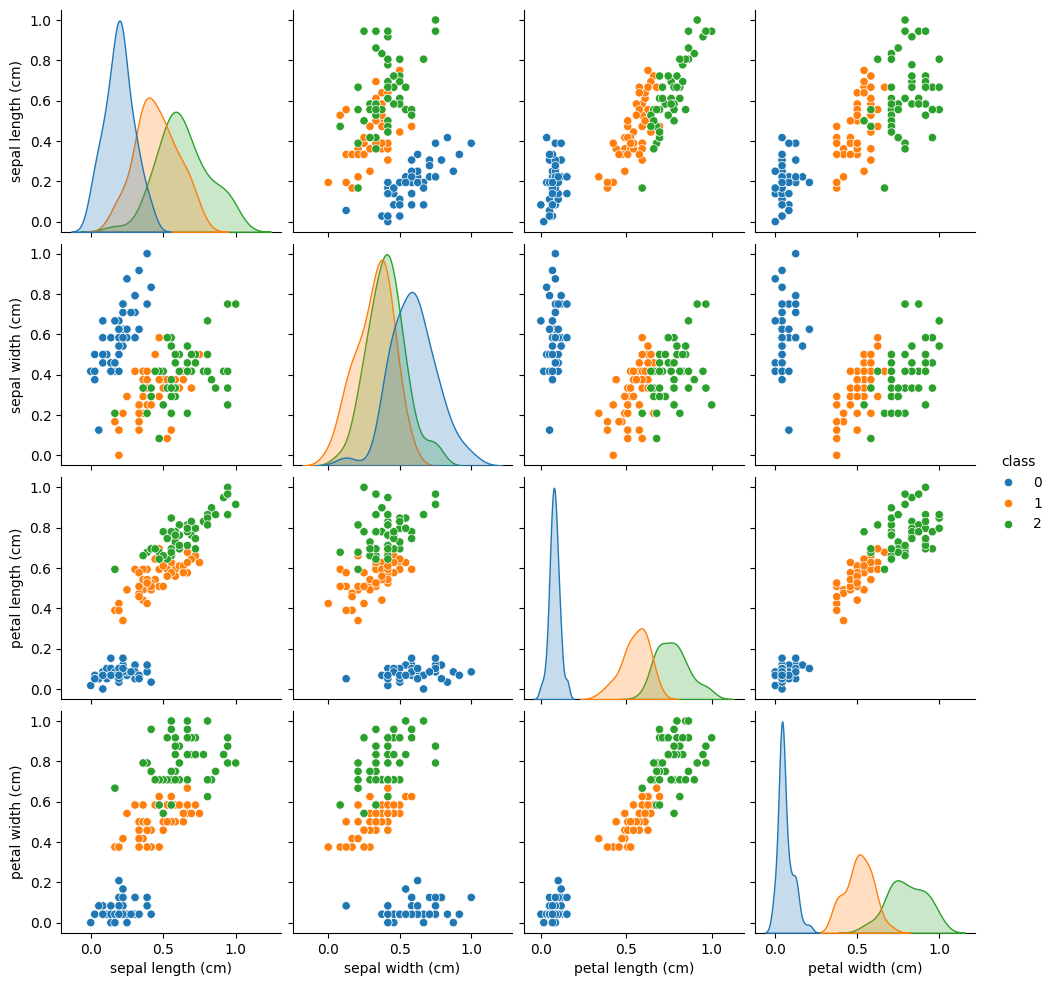

In [17]:
sns.pairplot(df, hue="class", palette="tab10")

Z otrzymanego wykresu łatwo zauwazyć iz klasa `0` jest dobrze separowalna szczególnie dla zmiennej `sepal width`.

## Klasyczny model SVC

In [15]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals



algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


## Kodowanie danych - ZZFeatureMap 

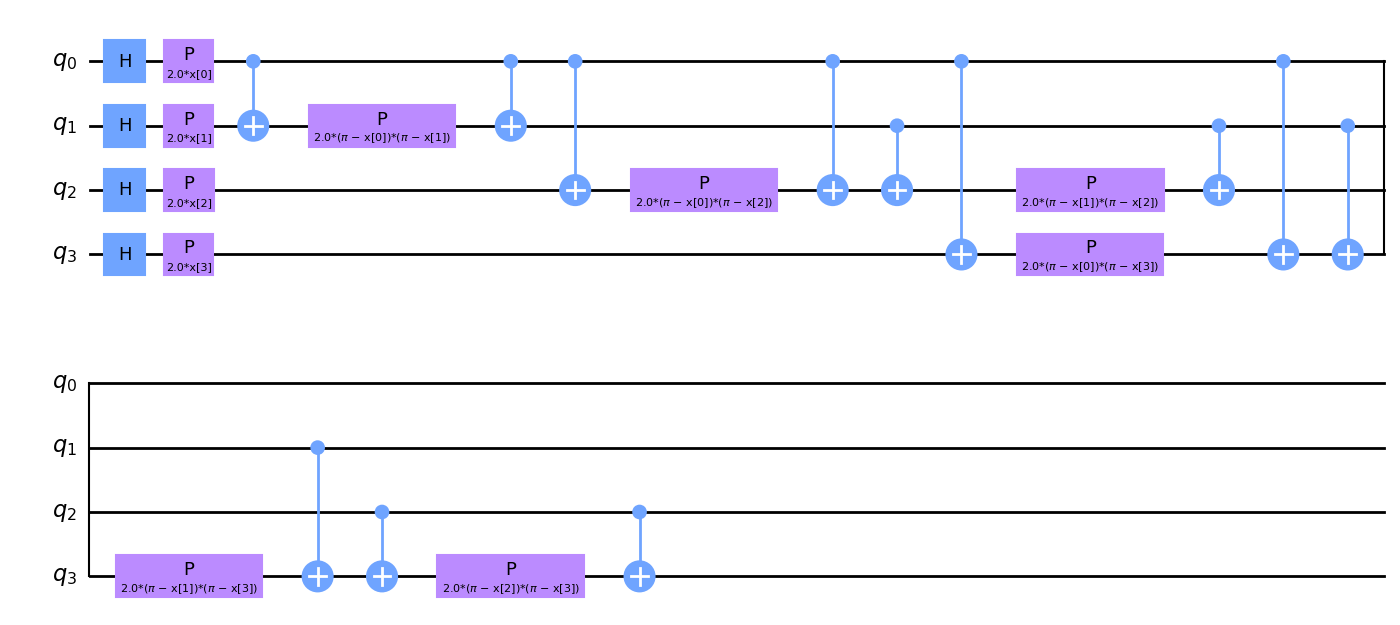

In [18]:
from qiskit.circuit.library import ZZFeatureMap
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

Przyjrzyj się uwaznie i zobacz, ze obwód ten jest parametryzowany przez cztery zmienne $x \left[ 0 \right],\ldots x\left[3\right]$. 

## Wybór modelu - RealAmplitudes


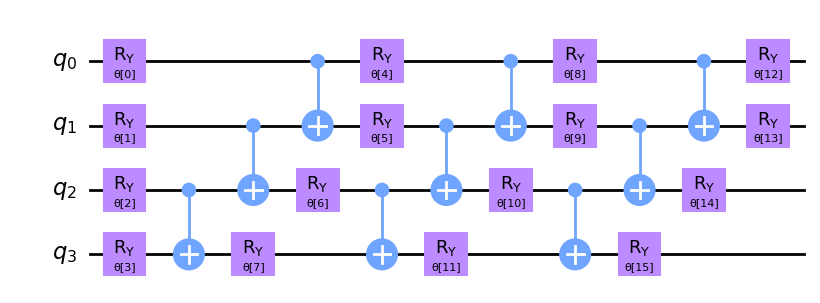

In [19]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

## Wybór optymalizatora COBYLA

In [20]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [21]:
from qiskit.primitives import Sampler

sampler = Sampler()

Zdefiniujmy dodatkową funkcję pozwalającą przeglądać postęp uczenia modelu.

In [22]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Variational Quantum Classifier 

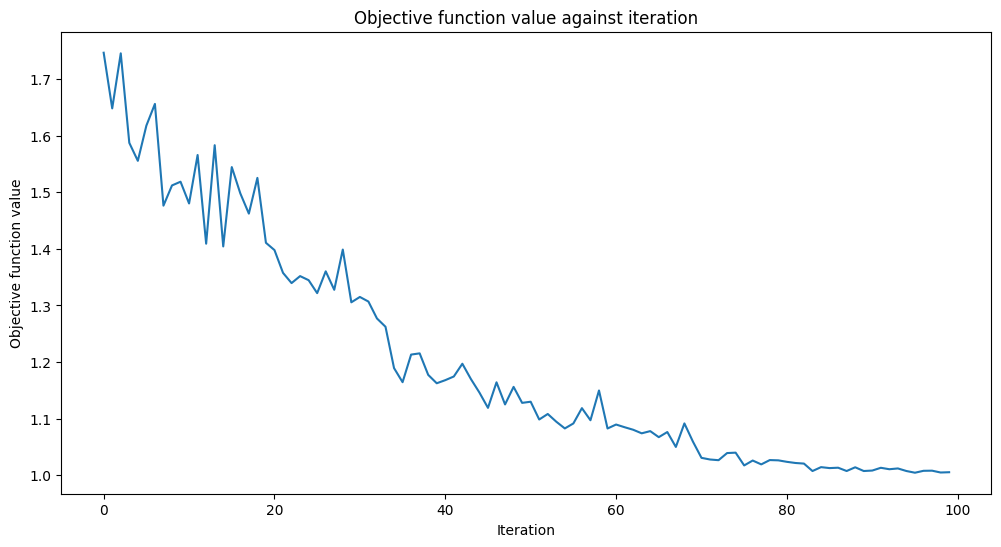

Training time: 37 seconds


In [23]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [24]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87
